# Import

In [1]:
import re
import ast
import pandas as pd
import requests
import numpy as np
import json
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

# 1. CMU DATASET ANALYSIS

In [2]:
DATA_FOLDER = './datasets/'

In [3]:
# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB',
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name',
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'CMU_dataset/character.metadata.tsv', names=columns_char,
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])

# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

cmu_df = pd.read_table(DATA_FOLDER+'CMU_dataset/movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

### Pre-processing of the data

Let us try to run a general structural analysis in order to get in touch with our dataframes.

DataFrame Shape: (81741, 9)

Data Types Counts:
object     6
float64    2
int64      1
Name: count, dtype: int64


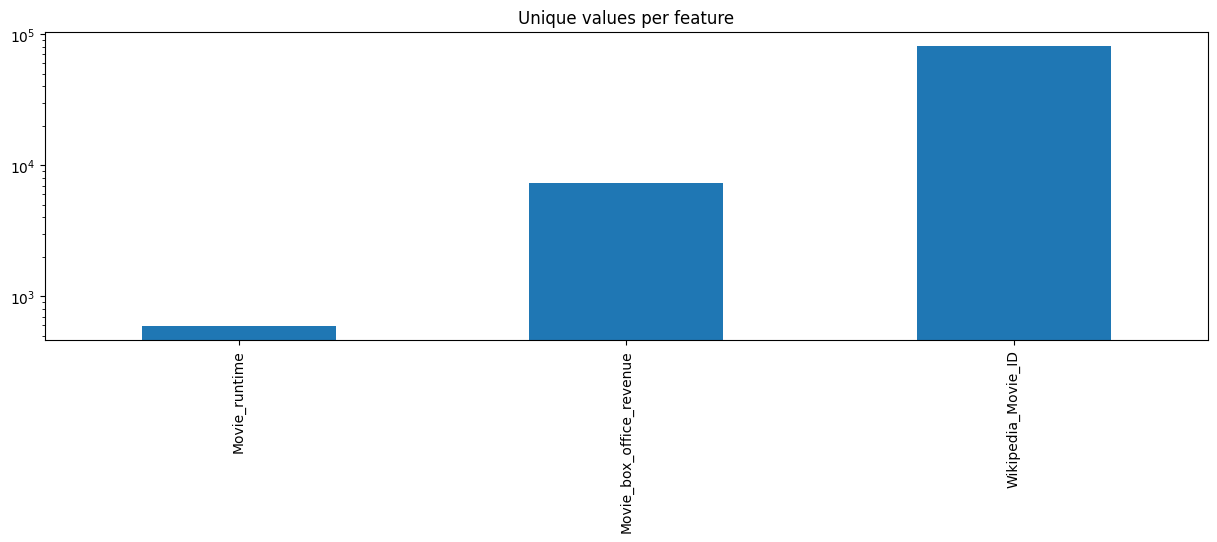

In [4]:
structural_analysis (cmu_df)

DataFrame Shape: (450669, 10)

Data Types Counts:
object     7
float64    2
int64      1
Name: count, dtype: int64


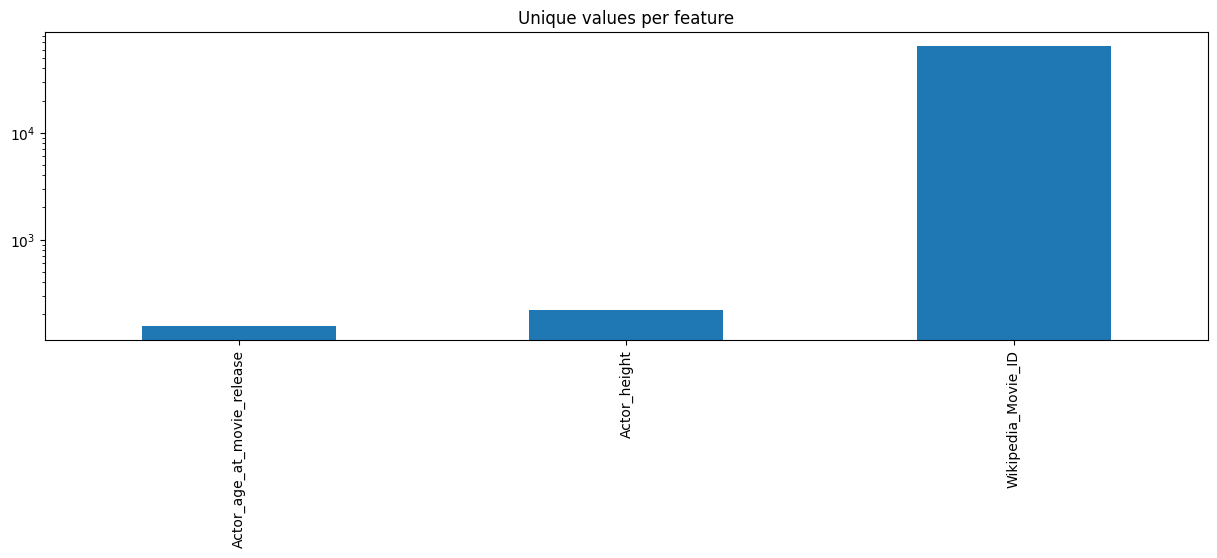

In [5]:
structural_analysis(characters)

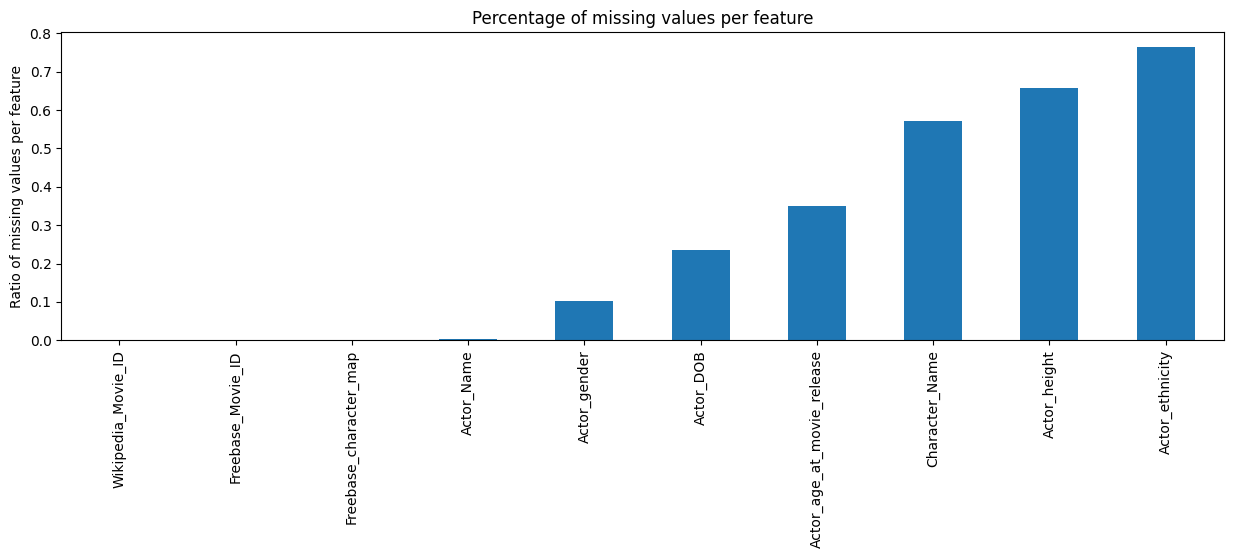

In [6]:
plot_missing_values_percenatage(characters)

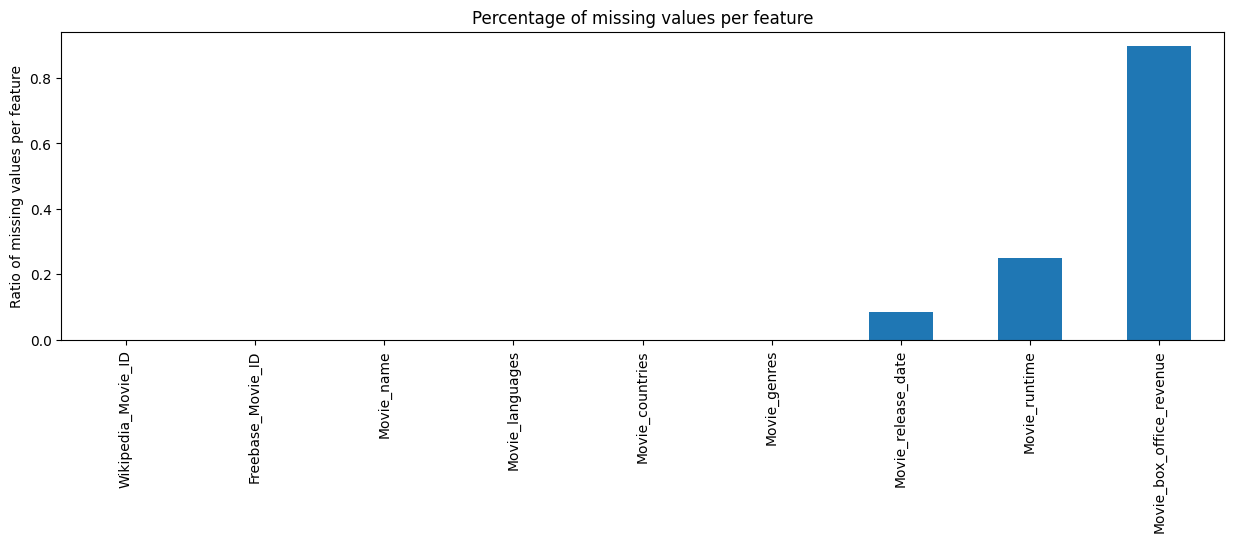

In [7]:
plot_missing_values_percenatage(cmu_df)

Let us now plot the distribution of the continuous values for each of the continuous features of each of the two dataframe, meaning Movie_runtime and Movie_box_office_revenue for movies and Actor_height and Actor_weight for character

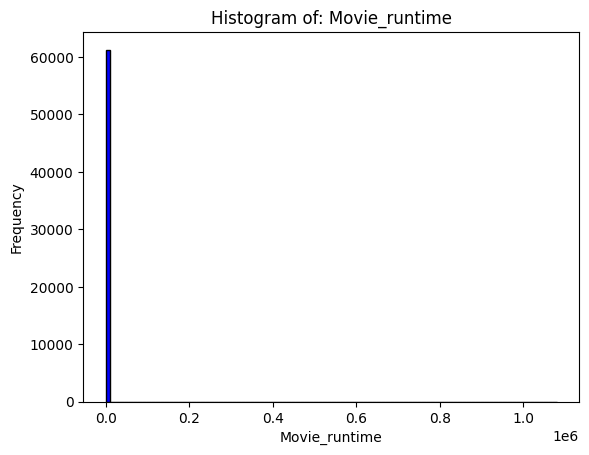

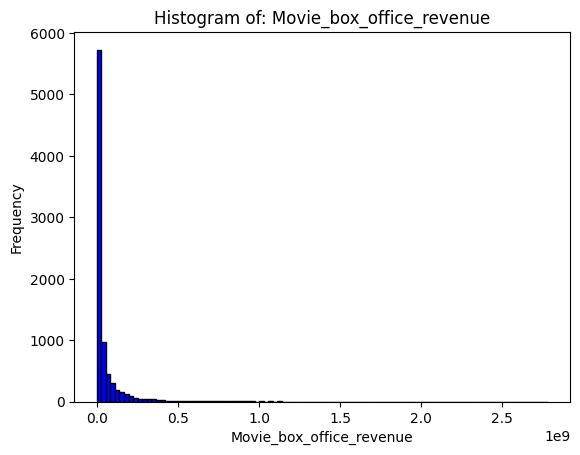

In [8]:
plot_histograms(cmu_df, ['Movie_runtime', 'Movie_box_office_revenue'])

The reason the first histogram looks like this is because of outliers, let us dig more into it


In [9]:
cmu_df['Movie_runtime'].describe()

count    6.129100e+04
mean     1.118192e+02
std      4.360070e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie_runtime, dtype: float64

We see that some movies have runtimes exceeding a million minutes. Let us remove such outliers.

In [10]:
cmu_df = cmu_df[cmu_df['Movie_runtime']<=1000]

Now let us plot the histograms again to se if this changes anything

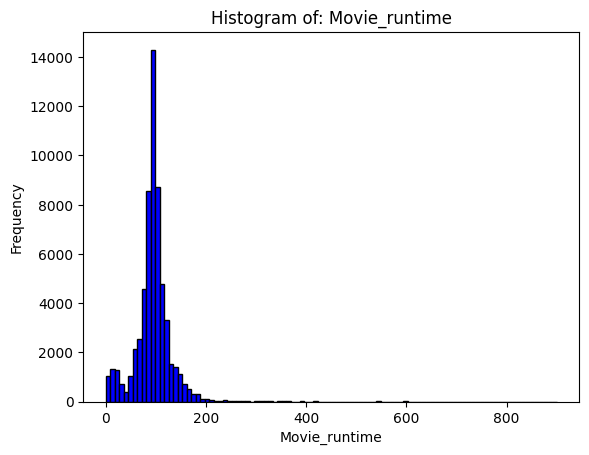

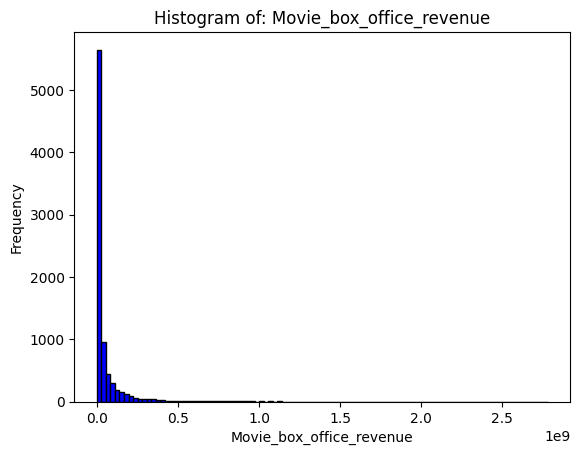

In [11]:
plot_histograms(cmu_df, ['Movie_runtime', 'Movie_box_office_revenue'])

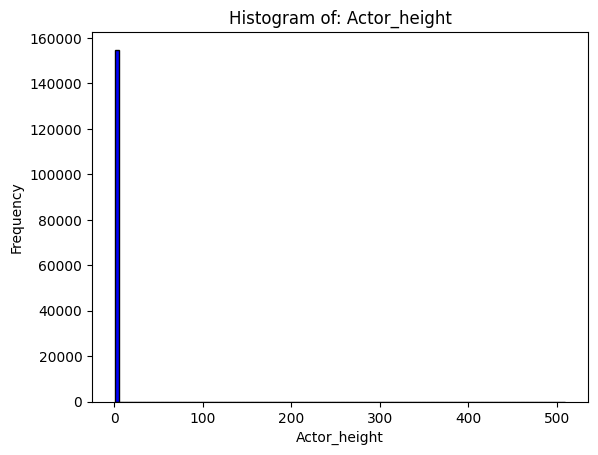

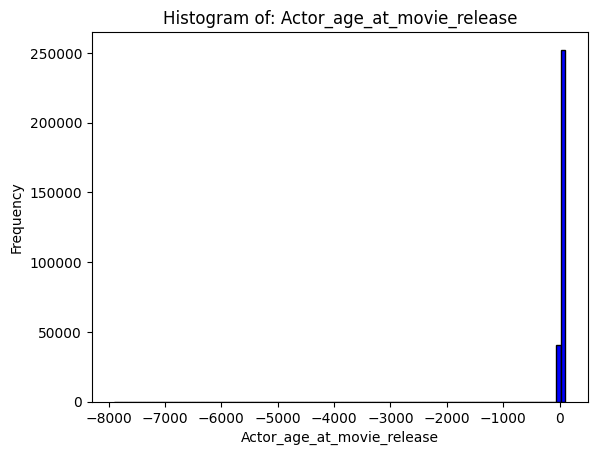

In [12]:
plot_histograms(characters, ['Actor_height', 'Actor_age_at_movie_release'])

Again, it seems like there are some actors with negative ages, and verry hight heights.

In [13]:
characters = characters[(characters['Actor_age_at_movie_release']>=0) & (characters['Actor_height'] <= 3)]

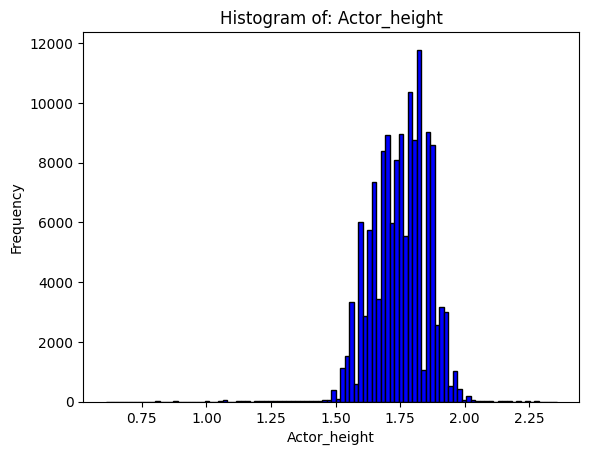

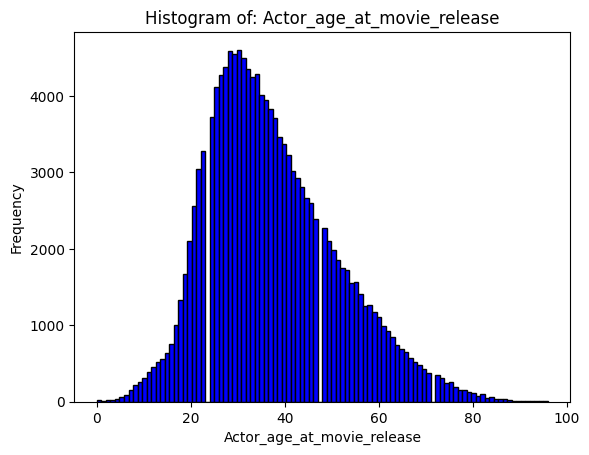

In [14]:
plot_histograms(characters, ['Actor_height', 'Actor_age_at_movie_release'])

In this first part of the notebook, we will process the data to clean them and structure them in a more convinient way for our coming analysis.

First, to make our future studies easier, we will split the release date column into two new columns containing the release month and year separately.

In [15]:
def split_date(df, dates):
    """
    Define a function to split the date into year and month
    Input: df to modify and its column dates
    """
    movie_release_year = []
    movie_release_month = []
    
    for release_date in dates:
        if '-' in str(release_date):
            splitted_date = release_date.split('-')
            movie_release_year.append(splitted_date[0])
            movie_release_month.append(splitted_date[1])
        else :
            movie_release_year.append(str(release_date)[:4])
            movie_release_month.append(None)
    df['Movie_release_year'] = movie_release_year
    df['Movie_release_month'] = movie_release_month
    df.drop('Movie_release_date', axis = 1, inplace = True)

In [16]:
split_date(cmu_df, cmu_df['Movie_release_date'])

cmu_df.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,None


Let us now focus more specifically on the year of release.

In [17]:
#It seems that a movie has a release date of 1010, this is clearly an outlier.

cmu_df.groupby('Movie_release_year').size()

Movie_release_year
1010       1
1888       1
1891       3
1893       1
1894       6
        ... 
2011    1367
2012     610
2013      21
2015       1
nan     2657
Length: 126, dtype: int64

Since there is only one outlier, we could check the true value of the release date of the film (it was released in 2010) and simply replace it, instead of dropping the movie.

In [19]:
cmu_df.Movie_release_year = cmu_df.Movie_release_year.replace('1010', '2010')

Regarding other features, since we do not aim to use graph representation, we have to drop the IDs in front of the languages, the movie genre and movie countries.

In [20]:
def split_action_advent(genres):
    '''
    Split the movie genre 'Action/Adventure' (if present)
    into the two distinct genres 'Action' & 'Adventure'
    :param genres: list of genres of a movie
    :return: eventually modified list of movie genre
    '''
    if 'Action/Adventure' in genres:
        idx = genres.index('Action/Adventure')
        genres[idx: idx+1] = ('Action', 'Adventure')
    return genres 

In [21]:
# Drop IDs before movie language, genre and country and split feature values into a list

cmu_df['Movie_genres'] = cmu_df['Movie_genres'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

cmu_df['Movie_countries'] = cmu_df['Movie_countries'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

cmu_df['Movie_languages'] = cmu_df['Movie_languages'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', '').replace(' Language', ''))[1::2])

In [22]:
# Split genre Action/Adventure in two different genres

cmu_df['Movie_genres'] = cmu_df['Movie_genres'].apply(split_action_advent)

# Drop unrelevant genre
cmu_df['Movie_genres'] = cmu_df[cmu_df['Movie_genres']!='Film \u00e0']['Movie_genres']

In [23]:
cmu_df.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None


Movies can have multiple countries. In order to work with them in a convenient way, we only keep the 3 first countries for each movie.

In [24]:
# Keep only the 3 first countries

cmu_df['Movie_countries'] = cmu_df['Movie_countries'].apply(lambda x: x[:3])

# Create new column for the 3 countries

countries = [[], [], []]

for country in cmu_df['Movie_countries']:
    for i in range(3):
        if i < len(country):
            countries[i].append(str(country[i]))
        else:
            countries[i].append(np.nan)

cmu_df['Movie_country_1'] = countries[0]
cmu_df['Movie_country_2'] = countries[1]
cmu_df['Movie_country_3'] = countries[2]

#cmu_df = cmu_df.drop(columns='Movie_countries')

Also, movies can have multiple genres, so we only keep the three first ones.

In [25]:
# Keep only the 3 first genre

cmu_df['Movie_genres'] = cmu_df['Movie_genres'].apply(lambda x: x[:3])

# Create new column for the 3 genre

genres = [[], [], []]

for genre in cmu_df['Movie_genres']:
    for i in range(3):
        if i < len(genre):
            genres[i].append(str(genre[i]))
        else:
            genres[i].append(np.nan)

cmu_df['Movie_genre_1'] = genres[0]
cmu_df['Movie_genre_2'] = genres[1]
cmu_df['Movie_genre_3'] = genres[2]

cmu_df = cmu_df.drop(columns='Movie_genres')

Finally, empty lists in the columns `Movie_languages` and `Movie_countries` have to be replaced by nan values.

In [26]:
# Replace missing values in list features by np.nan

cmu_df['Movie_languages'] = cmu_df['Movie_languages'].apply(lambda x: np.nan if x == [] else x)

### Visualize data set

#### 1) Movies

Let us first focus on movies dataset. We wish to visualize the distribution of the most common movie contries (i.e. countries of production), the distribution of the common genres and finally we will plot a bar chart of the missing values.

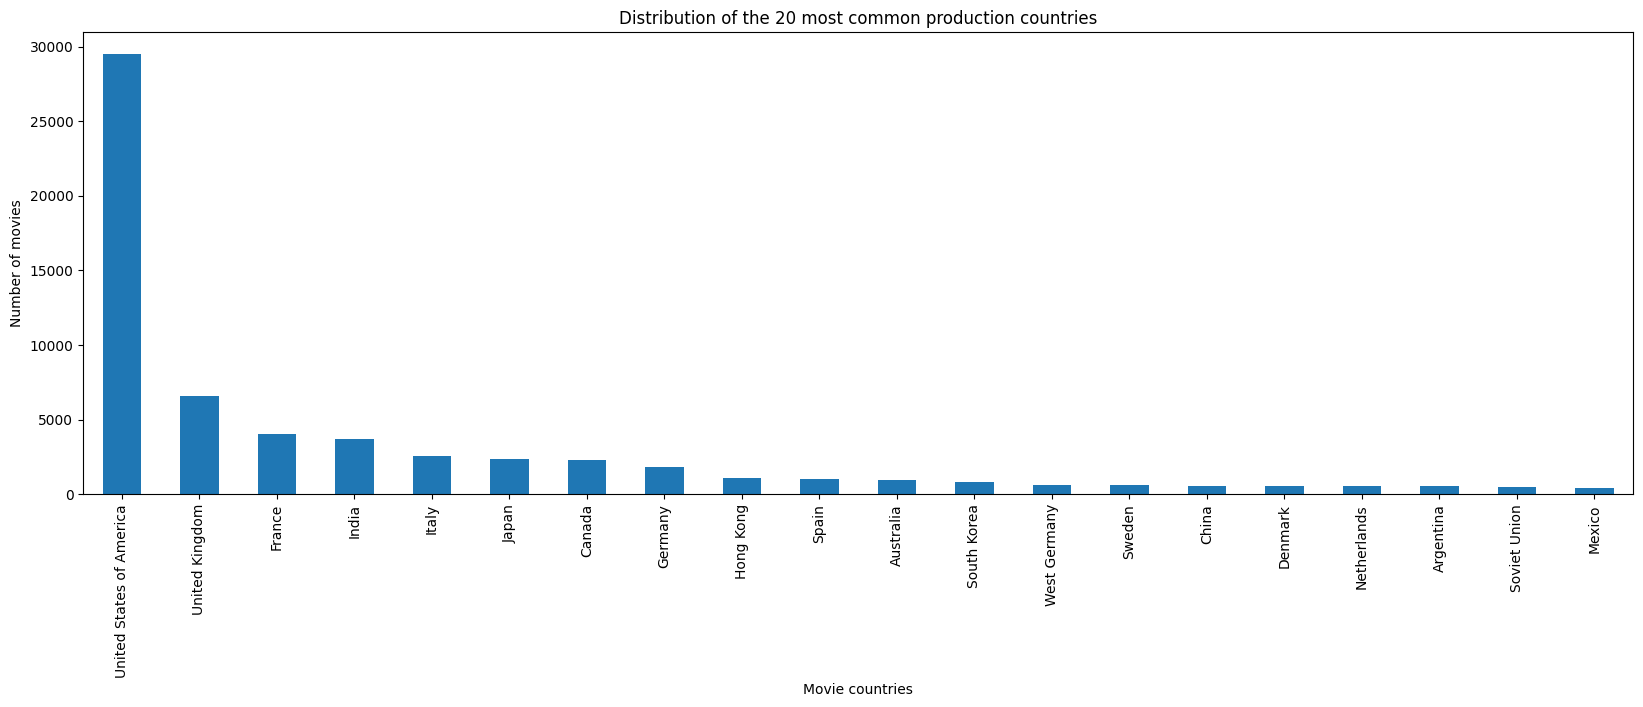

In [28]:
plot_top_20_most_popular(cmu_df,['Movie_country_1', 'Movie_country_2', 'Movie_country_3'],'Movie countries',"Distribution of the 20 most common production countries")

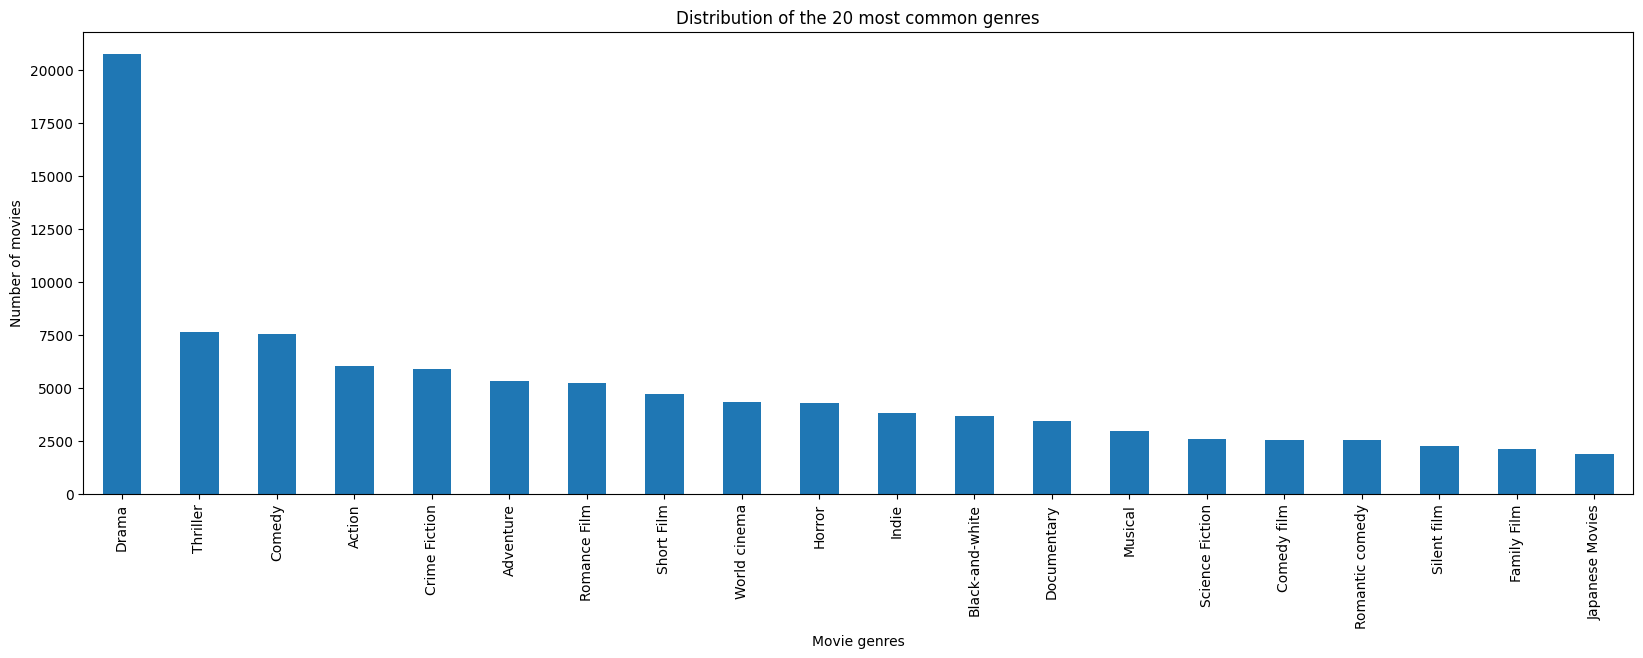

In [30]:
plot_top_20_most_popular(cmu_df,['Movie_genre_1', 'Movie_genre_2', 'Movie_genre_3'],'Movie genres', "Distribution of the 20 most common genres")

In [31]:
genres = cmu_df[['Movie_genre_1', 'Movie_genre_2', 'Movie_genre_3']].apply(pd.Series.value_counts).sum(axis=1)

In [32]:
top20_genres = genres.sort_values(ascending = False)[:20]

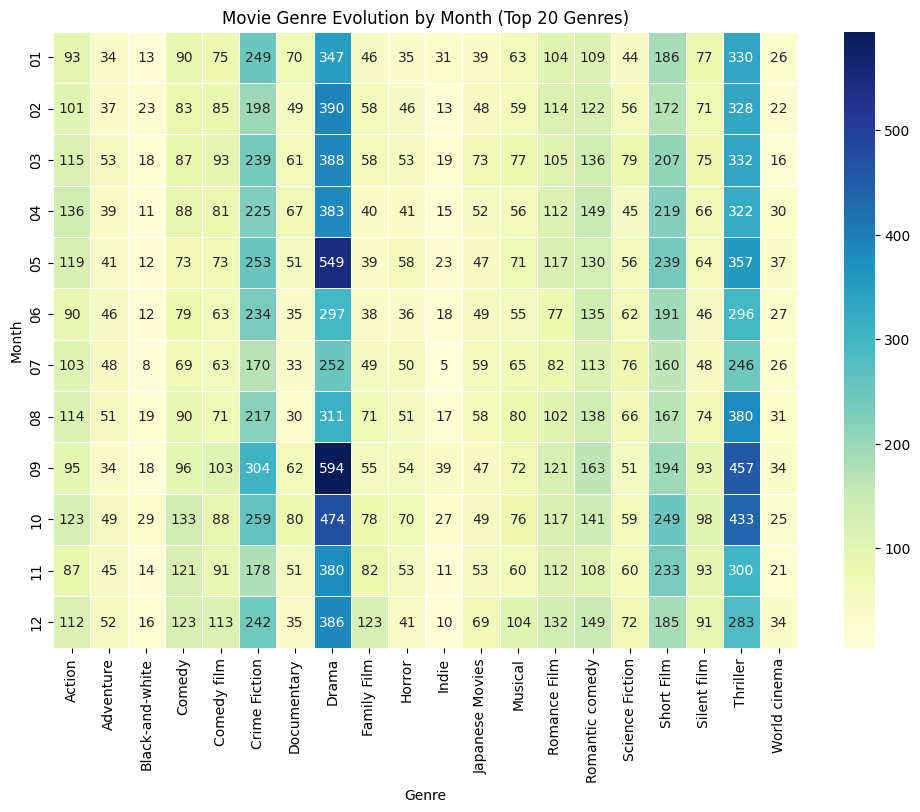

In [33]:
top_20_movies = cmu_df[cmu_df['Movie_genre_1'].isin(top20_genres.index)]

# Group the data by month and genre and calculate the count of cmu_df in each category
genre_month_counts = top_20_movies.groupby(['Movie_release_month', 'Movie_genre_1']).size().unstack(fill_value=0)

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(genre_month_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre Evolution by Month (Top 20 Genres)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

As we can see, there are a lot of missing values (about 89%) in the `Movie_box_office_revenue` column. This is an major issue to perform different analysis of the success of a film. This serves as motivation to work with other datasets for our future analysis to complete this one.

Other high values of missing data such as `Movie_country_2` and `Movie_country_3` are not alarming since most of the movies already have information in `Movie_country_1` and may solely have one production country. This is the same for `Movie_genre_`.

In [34]:
characters.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [35]:
characters[characters['Freebase_character_map']=='/m/02nwzzv'][:]

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
132619,54166,/m/0f4yh,Dr. Marcus Brody,1922-05-31,M,1.816,NaN,Denholm Elliott,59.0,/m/02nwzzv


Let us look at the gender repartition between actors


In [36]:
gender_counts = characters.groupby('Actor_gender').size()

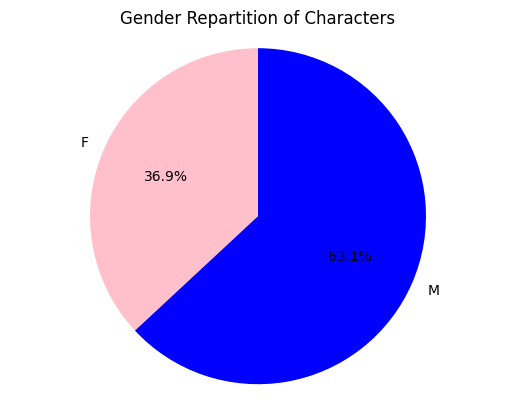

In [37]:
# Plotting a pie chart
fig, ax = plt.subplots()
ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'blue'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set the title
plt.title('Gender Repartition of Characters')

# Show the plot
plt.show()

### Creating a mapping between the IMDB Id and the Freebase_Movie_ID

In [4]:
def query_wikidata():
    url = 'https://query.wikidata.org/sparql'
    query = """
    SELECT ?item ?imdb ?freebase WHERE {
      ?item wdt:P345 ?imdb.
      ?item wdt:P646 ?freebase.
    }
    """
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()
    return data

In [5]:
data = query_wikidata()

In [6]:
def json_to_df(data):
    imdb_ids = []
    freebase_ids = []
    for item in data['results']['bindings']:
        imdb_ids.append(item['imdb']['value'])
        freebase_ids.append(item['freebase']['value'])
    df = pd.DataFrame({'imdb_id': imdb_ids, 'freebase_id': freebase_ids})
    return df

In [7]:
imbd_freebase = json_to_df(data)

In [16]:
imbd_freebase.drop_duplicates(subset=['imdb_id','freebase_id'], inplace=True)

# 2. TMBD Analysis

In [17]:
pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')
pd_tmbd

/var/folders/v2/6cxx8khs0hs5nml1jx68qgk40000gn/T/ipykernel_25061/2511636517.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_tmbd = pd.read_csv('./datasets/TMBD_Dataset/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


### Drop Non-related Columns

In [18]:
pd_tmbd = pd_tmbd.drop(['adult', 'belongs_to_collection',  'homepage', 'original_title', 'overview', 'poster_path', 'status', 'tagline', 'video'], axis=1)
pd_tmbd

,budget,genres,id,imdb_id,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,7.7,5415.0
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,6.9,2413.0
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Grumpier Old Men,6.5,92.0
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Waiting to Exhale,6.1,34.0
4,0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Father of the Bride Part II,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,tt6209470,fa,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Subdue,4.0,1.0
45462,0,"[{'id': 18, 'name': 'Drama'}]",111109,tt2028550,tl,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Century of Birthing,9.0,3.0
45463,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,tt0303758,en,0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Betrayal,3.8,6.0
45464,0,[],227506,tt0008536,en,0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,0.0,87.0,[],Satan Triumphant,0.0,0.0


In [19]:
def safe_literal_eval(x):
    try:
        return ast.literal_eval(x)
    except ValueError:
        return []


def get_names(x):
    try:
        result = []
        for d in x:
            result.append(d['name'])
        return result
    except TypeError:
        return []


#### Evaluate the literal value to convert it to array

In [20]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: safe_literal_eval(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: safe_literal_eval(x))

#### Convert the initial dictonnaries into array of items

In [21]:
# Apply the function to the 'genre' column
pd_tmbd['genres'] = pd_tmbd['genres'].apply(lambda x: get_names(x))

# Apply the function to the 'production_companies' column
pd_tmbd['production_companies'] = pd_tmbd['production_companies'].apply(lambda x: get_names(x))

# Apply the function to the 'production_countries' column
pd_tmbd['production_countries'] = pd_tmbd['production_countries'].apply(lambda x: get_names(x))

# Apply the function to the 'spoken_languages' column
pd_tmbd['spoken_languages'] = pd_tmbd['spoken_languages'].apply(lambda x: get_names(x))

### Merging the CMU and the TMDB Datasets

In [22]:
cmu_df = pd.merge(left=cmu_df, right=imbd_freebase, right_on='freebase_id', left_on='Freebase_Movie_ID', how='inner').drop(columns='freebase_id')

In [23]:
movies = pd.merge(right=cmu_df, left=pd_tmbd, on='imdb_id', how='inner').drop_duplicates(subset='imdb_id')

### Box Office Revenue Data Consolidation

In [24]:
movies['revenue'].replace(0.0, np.nan, inplace=True)
movies['Movie_box_office_revenue'].replace(0.0, np.nan, inplace=True)

In [25]:
movies['revenue'] = movies['revenue'].fillna(movies['Movie_box_office_revenue'])
movies['Movie_box_office_revenue'] = movies['Movie_box_office_revenue'].fillna(movies['revenue'])
movies.drop(columns='revenue', inplace=True)

In [26]:
movies = movies.dropna(subset=['Movie_box_office_revenue'])

### Preprocessing the columns

In [30]:
def transform_row(row):
    res = list(json.loads(row).values())
    return res

In [31]:
movies['Movie_genres'] = movies['Movie_genres'].apply(transform_row)
movies['Movie_countries'] = movies['Movie_countries'].apply(transform_row)
movies['Movie_languages'] = movies['Movie_languages'].apply(transform_row)

In [32]:
movies.drop(columns=['Wikipedia_Movie_ID', 'Freebase_Movie_ID','Movie_release_date', 'title', 'runtime', 'original_language', 'production_companies','id'], axis=1, inplace=True)